An experiment in creating a robot that will imitate me on Twitter.

---

So, I'm taking a Machine Learning course this semester in school, and one of the topics we keep coming back to is natural language processing and the 'bag of words' data structure. That is, given a sentence:

`How much wood would a woodchuck chuck if a woodchuck could chuck wood?`

We can represent that sentence as the following list:

`{
    How: 1
    much: 1
    wood: 2
    would: 2
    a: 2
    woodchuck: 2
    chuck: 2
    if: 1
}`

Ignoring *where* the words happened, we're just interested in how *often* the words occurred. That got me thinking: I wonder what would happen if I built a robot that just imitated how often I said things? It's dangerous territory when computer scientists ask "what if," but I got curious enough I wanted to follow through.

## The Objective

Given an input list of Tweets, build up the following things:

1. The distribution of starting words; since there are no "prior" words to go from, we need to treat this as a special case.
2. The distribution of words given a previous word; for example, every time I use the word `woodchuck` in the example sentence, there is a 50% chance it is followed by `chuck` and a 50% chance it is followed by `could`. I need this distribution for all words.
3. The distribution of quantity of hashtags; Do I most often use just one? Two? Do they follow something like a Poisson distribution?
4. Distribution of hashtags; Given a number of hashtags, what is the actual content? I'll treat hashtags as separate from the content of a tweet.

## The Data

I'm using as input my tweet history. I don't really use Twitter anymore, but it seems like a fun use of the dataset. I'd like to eventually build this to a point where I can imitate anyone on Twitter using their last 100 tweets or so, but I'll start with this as example code.

## The Algorithm

I'll be using the [NLTK](http://www.nltk.org/) library for doing a lot of the heavy lifting. First, let's import the data:

In [1]:
import pandas as pd

tweets = pd.read_csv('tweets.csv')
text = tweets.text

# Don't include tweets in reply to or mentioning people
replies = text.str.contains('@')
text_norep = text.loc[~replies]

And now that we've got data, let's start crunching. First, tokenize and build out the distribution of first word:

In [2]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = text_norep.map(tknzr.tokenize)

first_words = tokens.map(lambda x: x[0])
first_words_alpha = first_words[first_words.str.isalpha()]
first_word_dist = first_words_alpha.value_counts() / len(first_words_alpha)

Next, we need to build out the conditional distributions. That is, what is the probability of the next word given the current word is $X$? This one is a bit more involved. First, find all unique words, and then find what words proceed them. This can probably be done in a more efficient manner than I'm currently doing here, but we'll ignore that for the moment.

In [3]:
from functools import reduce

# Get all possible words
all_words = reduce(lambda x, y: x+y, tokens, [])
unique_words = set(all_words)
actual_words = set([x if x[0] != '.' else None for x in unique_words])

word_dist = {}
for word in iter(actual_words):
    indices = [i for i, j in enumerate(all_words) if j == word]
    proceeding = [all_words[i+1] for i in indices]
    word_dist[word] = proceeding

Now that we've got the tweet analysis done, it's time for the fun part: hashtags! Let's count how many hashtags are in each tweet, I want to get a sense of the distribution.

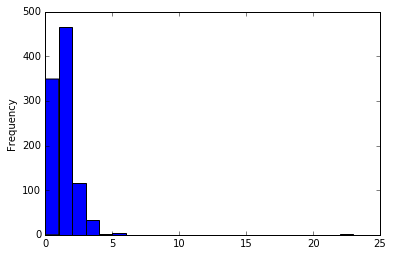

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

hashtags = text_norep.str.count('#')
bins = hashtags.unique().max()
hashtags.plot(kind='hist', bins=bins)

That looks like a Poisson distribution, kind of as I expected. I'm guessing my number of hashtags per tweet is $\sim Poi(1)$, but let's actually find the [most likely estimator](https://en.wikipedia.org/wiki/Poisson_distribution#Maximum_likelihood) which in this case is just $\bar{\lambda}$:

In [5]:
mle = hashtags.mean()
mle

0.870236869207003

Pretty close! So we can now simulate how many hashtags are in a tweet. Let's also find what hashtags are actually used:

In [6]:
hashtags = [x for x in all_words if x[0] == '#']
n_hashtags = len(hashtags)

unique_hashtags = list(set([x for x in unique_words if x[0] == '#']))
hashtag_dist = pd.DataFrame({'hashtags': unique_hashtags,
                             'prob': [all_words.count(h) / n_hashtags
                                      for h in unique_hashtags]})
len(hashtag_dist)

603

Turns out I have used 603 different hashtags during my time on Twitter. That means I was using a unique hashtag for about every third tweet.

In better news though, we now have all the data we need to go about actually constructing tweets! The process will happen in a few steps:

1. Randomly select what the first word will be.
2. Randomly select the number of hashtags for this tweet, and then select the actual hashtags.
3. Fill in the remaining space of 140 characters with random words taken from my tweets.

And hopefully, we won't have anything too crazy come out the other end. The way we do the selection follows a [Multinomial Distribution](https://en.wikipedia.org/wiki/Multinomial_distribution): given a lot of different values with specific probability, pick one. Let's give a quick example:

```
x: .33
y: .5
z: .17
```

That is, I pick `x` with probability 33%, `y` with probability 50%, and so on. In context of our sentence construction, I've built out the probabilities of specific words already - now I just need to simulate that distribution. Time for the engine to actually be developed!

In [7]:
import numpy as np

def multinom_sim(n, vals, probs):
    occurrences = np.random.multinomial(n, probs)
    results = occurrences * vals
    return ' '.join(results[results != ''])

def sim_n_hashtags(hashtag_freq):
    return np.random.poisson(hashtag_freq)

def sim_hashtags(n, hashtag_dist):
    return multinom_sim(n, hashtag_dist.hashtags, hashtag_dist.prob)

def sim_first_word(first_word_dist):
    probs = np.float64(first_word_dist.values)
    return multinom_sim(1, first_word_dist.reset_index()['index'], probs)

def sim_next_word(current, word_dist):
    dist = pd.Series(word_dist[current])
    probs = np.ones(len(dist)) / len(dist)
    return multinom_sim(1, dist, probs)

## Pulling it all together

I've now built out all the code I need to actually simulate a sentence written by me. Let's try doing an example with five words and a single hashtag:

In [8]:
first = sim_first_word(first_word_dist)
second = sim_next_word(first, word_dist)
third = sim_next_word(second, word_dist)
fourth = sim_next_word(third, word_dist)
fifth = sim_next_word(fourth, word_dist)
hashtag = sim_hashtags(1, hashtag_dist)

' '.join((first, second, third, fourth, fifth, hashtag))

'My first all-nighter of friends #oldschool'

Let's go ahead and put everything together! We're going to simulate a first word, simulate the hashtags, and then simulate to fill the gap until we've either taken up all the space or reached a period.

In [9]:
def simulate_tweet():
    chars_remaining = 140
    first = sim_first_word(first_word_dist)
    n_hash = sim_n_hashtags(mle)
    hashtags = sim_hashtags(n_hash, hashtag_dist)
    
    chars_remaining -= len(first) + len(hashtags)
    
    tweet = first
    current = first
    while chars_remaining > len(tweet) + len(hashtags) and current[0] != '.' and current[0] != '!':
        current = sim_next_word(current, word_dist)
        tweet += ' ' + current
        
    tweet = tweet[:-2] + tweet[-1]
        
    return ' '.join((tweet, hashtags)).strip()

## The results

And now for something completely different: twenty random tweets dreamed up by my computer and my Twitter data. Here you go:

In [12]:
for i in range(0, 20):
    print(simulate_tweet())
    print()

Also , I'm at 8 this morning. #thursdaysgohard #ornot

Turns out of us breathe the code will want to my undergraduate career is becoming more night trying ? Religion is now as a chane #HYPE

You know what recursion is to review the UNCC. #ornot

There are really sore 3 bonfires in my first writing the library ground floor if awesome. #realtalk #impressed

So we can make it out there's nothing but I'm not let us so hot I could think I may be good. #SwingDance

Happy Christmas , at Harris Teeter to be be godly or Roman Catholic ). #4b392b#4b392b #Isaiah26

For context , I in the most decisive factor of the same for homework. #accomplishment

Freaking done. #loveyouall

New blog post : Don't jump in a quiz in with a knife fight. #haskell #earlybirthday

God shows me legitimately want to get some food and one day.

Stormed the queen city. #mindblown

The day of a cold at least outside right before the semester ..

Finished with the way back. #winners

Waking up , OJ , I feel like Nick Jona

...Which all ended up being a whole lot more nonsensical than I had hoped for. There are some good ones, so I'll call that an accomplishment! I was banking on grammar not being an issue: since my tweets use impeccable grammar, the program modeled off them should have pretty good grammar as well. There are going to be some hilarious edge cases (I'm looking at you, `Ethics paper first, music in close to everyone`) that make no sense, and some hilarious edge cases (`Waking up, OJ, I feel like Nick Jonas today`) that make me feel like I should have a Twitter rap career. On the whole though, the structure came out alright.

## Moving on from here

During class we also talked about an interesting idea: trying to analyze corporate documents and corporate speech. I'd be interested to know what this analysis applied to something like a couple of bank press releases could do. By any means, the code needs some work to clean it up before I get that far.

## For further reading

I'm pretty confident I re-invented a couple wheels along the way - what I'm doing feels a lot like what [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) is intended to do. But I've never worked explicitly with that before, so more research is needed.